
**NAMA : Raden Rian Girianom**    
**URL Dataset : [Click](https://www.kaggle.com/datasets/gatewayadam/cars-and-tanks-image-classification)**    
**Gambaran dataset adalah image yang berisikan binary classification yaitu tanks dan cars berisikan :       
735 training images of cars.    
586 training images of tanks.   
100 test images of each class.    
dan semua ukurannya adalah 256x256 pixel**

**Problem Statement : Berdasarkan laporan ICRC [Click](https://www.interaction.org/blog/when-war-moves-to-cities-protection-of-civilians-in-urban-areas-3/) Meningkatnya konflik peperangan di perkotaan (Urban warfare) dalam beberapa tahun belakang menimbulkan banyak korban masyarakat tidak bersenjata (civilian). Berdasarkan problem tersebut technology dalam perangkat militer mempunyai peranan penting untuk dilakukan peningkatan dalam mendeteksi object salah satunya ketika berada di jalanan perkotaan yang mana terdapat kendaraan non-militer, untuk mengurangi potensi korban pada masyarakat.**

**Objective : Membuat permodelan computer vision untuk mengklasifikasikan object Tanks atau Cars menggunakan metrics f1-score**


## **Import Libraries**

In [ ]:
# Import Libraries
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

## **Data Loading**

In [ ]:
# Mengambil dataset dari kaggle langsung menggunakan step-by-step dibawauh
## Pertama Install Kaggle library terlebih dahulu
!pip install kaggle

## Kedua membuat directory bernama `.kaggle`
!mkdir ~/.kaggle

## ketiga Copy the kaggle.json ke directory
!cp kaggle.json ~/.kaggle/

## Keempat Set directory:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset
# source = https://www.kaggle.com/datasets/gatewayadam/cars-and-tanks-image-classification

!kaggle datasets download -d gatewayadam/cars-and-tanks-image-classification

 93% 49.0M/52.4M [00:00<00:00, 128MB/s]
100% 52.4M/52.4M [00:00<00:00, 119MB/s]


In [ ]:
# unzip dataset jika masih berbentuk zip
!unzip ./cars-and-tanks-image-classification.zip

Archive:  ./cars-and-tanks-image-classification.zip
  inflating: cars_tanks/test/cars/735.jpg  
  inflating: cars_tanks/test/cars/736.jpg  
  inflating: cars_tanks/test/cars/737.jpg  
  inflating: cars_tanks/test/cars/738.jpg  
  inflating: cars_tanks/test/cars/739.jpg  
  inflating: cars_tanks/test/cars/740.jpg  
  inflating: cars_tanks/test/cars/741.jpg  
  inflating: cars_tanks/test/cars/742.jpg  
  inflating: cars_tanks/test/cars/743.jpg  
  inflating: cars_tanks/test/cars/744.jpg  
  inflating: cars_tanks/test/cars/745.jpg  
  inflating: cars_tanks/test/cars/746.jpg  
  inflating: cars_tanks/test/cars/747.jpg  
  inflating: cars_tanks/test/cars/748.jpg  
  inflating: cars_tanks/test/cars/749.jpg  
  inflating: cars_tanks/test/cars/750.jpg  
  inflating: cars_tanks/test/cars/751.jpg  
  inflating: cars_tanks/test/cars/752.jpg  
  inflating: cars_tanks/test/cars/753.jpg  
  inflating: cars_tanks/test/cars/754.jpg  
  inflating: cars_tanks/test/cars/755.jpg  
  inflating: cars_tanks/

## **Exploratory Data Analysis (EDA)**

In [ ]:
# Define path training dan testing
main_path = '/content/cars_tanks/'
train_path = os.path.join(main_path, 'train')
test_path = os.path.join(main_path, 'test')

### **Menampilkan 5 image masing-masing Cars dan Tank**

In [ ]:
# Menampilkan 5 images pertama setiap class
def plot_images(path):
  labels = os.listdir(path)
  for label in labels:
    folder_path = os.path.join(path, label)
    fig = plt.figure(figsize=(15, 15))
    columns = 4
    rows = 1
    print('Class : ', label)
    images = os.listdir(folder_path)
    for index in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, index)
        image = plt.imread(os.path.join(folder_path, images[index]))
        plt.imshow(image)
        plt.axis("off")
    plt.show()

Class :  tanks


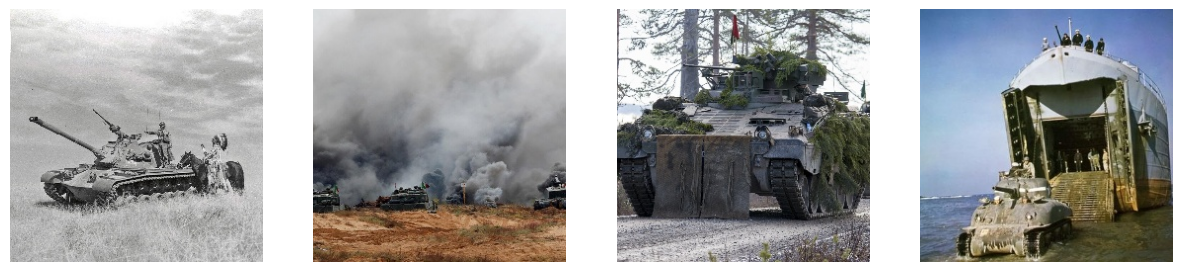

Class :  cars


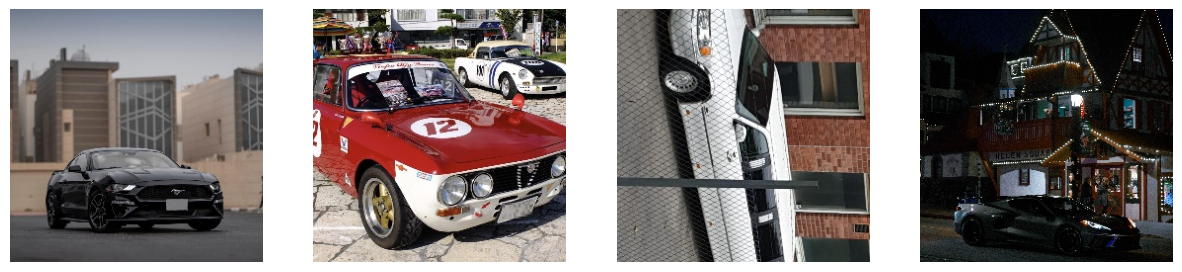

In [ ]:
# Visualization of train_path

plot_images(train_path)

### **Visualisasi distribusi masing-masing class**

Distribusi kelas dalam Training Set:


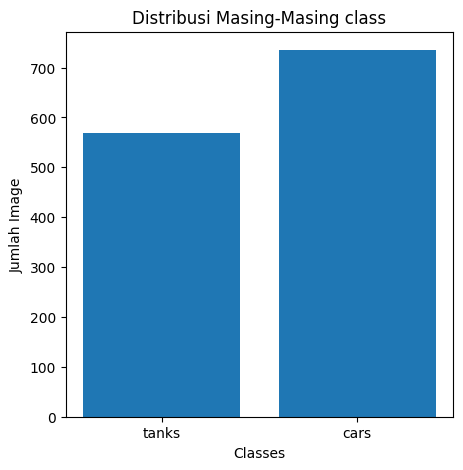

Distribusi kelas dalam Testing Set:


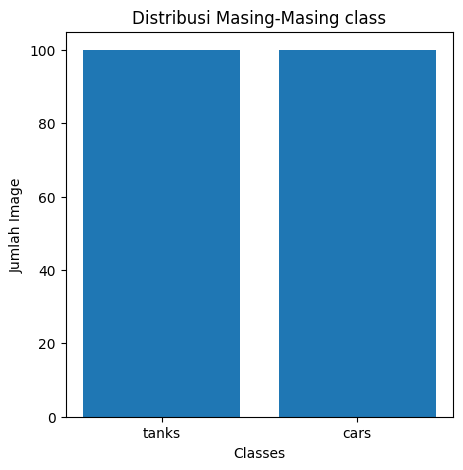

In [ ]:
# membuat function untuk menampilkan jumlah image dalam bentuk barplot
def visualiasi_distribution(data_path):
  classes = os.listdir(data_path)
  class_counts = {}
  for class_name in classes:
    class_path = os.path.join(data_path, class_name)
    num_images = len(os.listdir(class_path))
    class_counts[class_name] = num_images
  plt.figure(figsize=(5,5))
  plt.bar(class_counts.keys(), class_counts.values())
  plt.title('Distribusi Masing-Masing class')
  plt.xlabel('Classes')
  plt.ylabel('Jumlah Image')
  plt.show()

# Visualisasi distribusi gambar dalam data training dan testing
print("Distribusi kelas dalam Training Set:")
visualiasi_distribution(train_path)

print("Distribusi kelas dalam Testing Set:")
visualiasi_distribution(test_path)


In [ ]:
# membuat function untuk menampilkan jumlah image dalam bentuk numerical data
def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)
print('')

Train Path
Total Data - tanks : 568
Total Data - cars : 735

Test Path
Total Data - tanks : 100
Total Data - cars : 100



Jumlah image dalam training set untuk tank ada 568 dan cars 735   
Untuk image dalam testing 100 tank dan 100 cars masing-masing berimbang

## **Feature Engineering**

Normalisasi ukuran image dari dataset, karena dalam dataset image berukuran 256x256, maka dinormalisasi ukurannya menjadi 256x256.   
dan Batch size = 32 sebagai hyperparameter tuning, jumlah iamge yang akan diproses dalam training.

In [ ]:
# Normalisasi ukuran image
height= 256 # disamakan ukurannya
width= 256
batch_size= 32

Membuat train-set, val-set dan test-set berdasarkan parameter normalisasi image diatas

In [ ]:
# Create batch generator for train-set, val-set, and test-set

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./256., # fitur scaling 1/255
    validation_split=0.3) # 30 % untuk validasi

# Membuat train-validation untuk dipersiapkan data modeling
train_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(height,width),
    class_mode='binary', #binary untuk binary classification 0/1 (karena predict tank or cars maka binary 0/1)
    subset='training', # subset untuk training
    batch_size=batch_size,
    shuffle=True, # shuffle image dalam training = true
    seed=2) # set random state agar hasil tidak berubah, nilai bebas

val_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(height,width),
    class_mode='binary', #binary untuk binary classification 0/1 (karena predict tank or cars maka binary 0/1)
    subset='validation', # subset untuk validasi
    batch_size=batch_size,
    shuffle=True, # shuffle image dalam training = true
    seed=2) # set random state agar hasil tidak berubah, nilai bebas

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=(height,width),
    class_mode='binary', #binary untuk binary classification 0/1 (karena predict tank or cars maka binary 0/1)
    batch_size=batch_size,
    shuffle=False, # image untuk test_set tidak dilakukan shuffle
    seed=2) # set random state agar hasil tidak berubah, nilai bebas


Found 913 images belonging to 2 classes.
Found 390 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
# Show classes
train_set.class_indices

{'cars': 0, 'tanks': 1}

## **ANN Training (Sequential API/Functional API)**

Karena dataset merupakan computer vision (image) maka model yang digunakan dalam training deep learning adalah CNN = Convulisonal Neural Network

### **Model Definition**

In [ ]:
# Clear Architecture
seed = 2 # Seperti random state, set bebas agar hasil tetap
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
model = Sequential()

# Input Layer : Menggunakan convolutional layer (conv2d) untuk deteksi image
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(height, width,3))) #3,3 confolusion matrix

model.add(MaxPooling2D(2, 2)) # Mengurangi spatial dimensions pada image
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2)) # pooling downsampling diulang 3

# Flatten layer (wajib untuk image)
model.add(Flatten()) # karena dataset adalah gambar/image maka menggunakan flatten

# Layer connect
model.add(Dense(128, activation='relu'))

# Output layer, karena binary classification maka activation yang tepat adalah sigmoid dan 1 adalah neuron
model.add(Dense(1, activation='sigmoid'))

# Compile Model
model.compile(loss='binary_crossentropy', # binary_crossentropy karena binary classification class ada 2
              optimizer='adam', # paling umum digunakan
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 128)               3

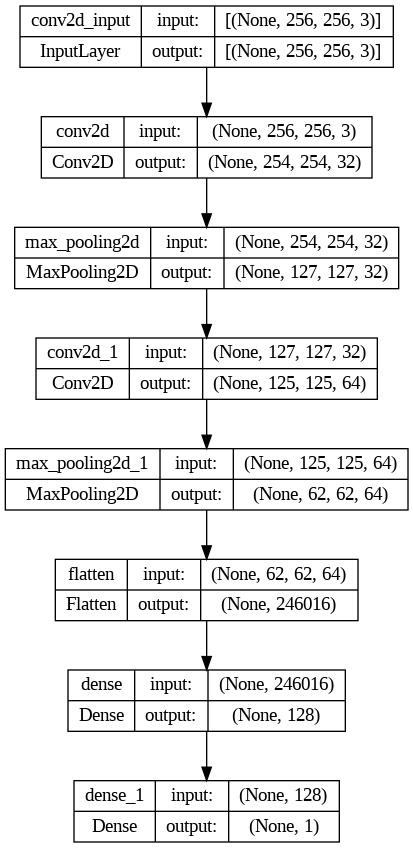

In [ ]:
# Plot layers

tf.keras.utils.plot_model(model, show_shapes=True)

**Architecture Model diatas sebagai berikut =**
1. Menggunakan Sequential API karena :      
  a.  model yang dibuat tidak terlalu kompleks. Hanya satu input dan output layer dengan pemrosesan iamge (gambar) mempunyai 3 channel warna RGB

2. Untuk Input layer menggunakan convulusion Conv2D dengan 32 filter yang akan memproses 3 channel warna RGB.  

3. Untuk Hidden Layer menggunakan Maxpooling2D seabgai pooling pertama dan Convulusional layer kedua untuk pemrosesan pada gambar.  

4. Untuk layer concat (connect layer) menggunakan :     
  4a. Dense dengan 128 neuron.      
  4b. flatten sebagai layer convert mengubah 2d menjadi 1D untuk pemrosesan computer vision image.

5. Output Layer dengan aktivasi sigmoid dikarenakan outpu yang dihasilkan adalah binary classification

6. Compile Model      
   6a. loss='binary_crossentropy', karena binary classification class hanya ada 2 predict tanks atau cars   
   6b. optimizer='adam', Optimizer yang paling umum digunakan   
   6c. metrics = accuracy   

### **Model Training**

In [ ]:
# Train the model
%%time
train_non_improved = model.fit(train_set, epochs=25, validation_data=val_set, batch_size=batch_size)

# epoch = semakin banyak nilai epoch semakin lama waktu training tetapi hasilnya akan terlihat lebih jelas

Epoch 1/25
29/29 [==============================] - 17s 312ms/step - loss: 1.8151 - accuracy: 0.5290 - val_loss: 0.6056 - val_accuracy: 0.5641
Epoch 2/25
29/29 [==============================] - 5s 160ms/step - loss: 0.5776 - accuracy: 0.6396 - val_loss: 0.4972 - val_accuracy: 0.8179
Epoch 3/25
29/29 [==============================] - 3s 114ms/step - loss: 0.4083 - accuracy: 0.8149 - val_loss: 0.3975 - val_accuracy: 0.8256
Epoch 4/25
29/29 [==============================] - 3s 118ms/step - loss: 0.2765 - accuracy: 0.8883 - val_loss: 0.4332 - val_accuracy: 0.7974
Epoch 5/25
29/29 [==============================] - 6s 210ms/step - loss: 0.1747 - accuracy: 0.9474 - val_loss: 0.4607 - val_accuracy: 0.8282
Epoch 6/25
29/29 [==============================] - 3s 120ms/step - loss: 0.0602 - accuracy: 0.9836 - val_loss: 0.4827 - val_accuracy: 0.8256
Epoch 7/25
29/29 [==============================] - 3s 113ms/step - loss: 0.0176 - accuracy: 0.9989 - val_loss: 0.7828 - val_accuracy: 0.8154
Epoch

Dengan training menggunakan 25 epoch bertujuan untuk memperoleh hasil terbaik dengan beberapa hasil sebagai berikut =    
1. Waktu yang dibutuhkan untuk training model 25 epoch (dengan GPU T4) =       
CPU times: user 1min 44s, sys: 12.9 s, total: 1min 57s    
Wall time: 1min 43s        

2. Waktu yang dibutuhkan untuk training model 25 epoch (Tanpa GPU)=   
CPU times: user 1h 16min 2s, sys: 15min 50s, total: 1h 31min 53s    
Wall time: 1h 17s

### **Model Evaluation**

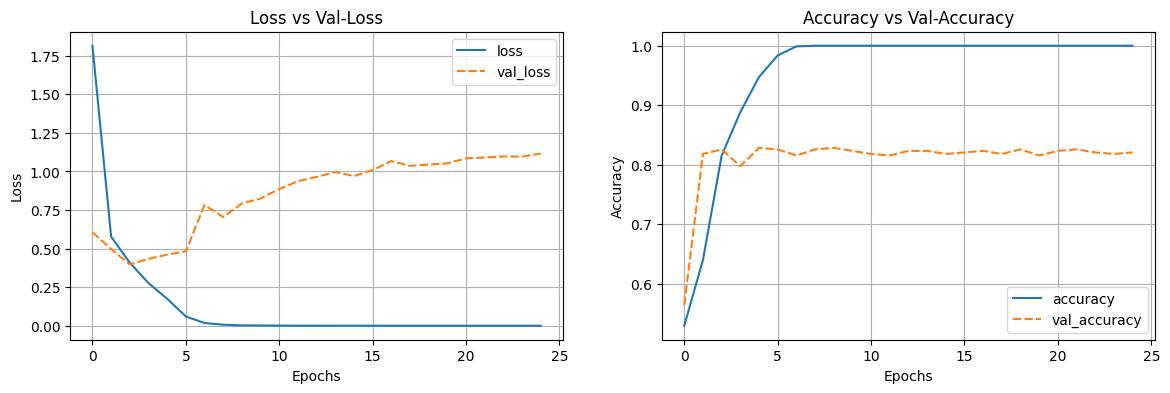

In [ ]:
# Plot training results

train_non_improved_df = pd.DataFrame(train_non_improved.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
sns.lineplot(data=train_non_improved_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=train_non_improved_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

**Untuk Loss vs Validation-Loss =**   
Dengan training model epoch sampai 25 : model diatas cenderung **overfit** dengan perbedaan gap loss dan val-loss yang besar dimulai dari epoch ke 6-7 sampai terakhir 25 lebih dari 1

**Untuk Accuracy vs Validation-accuracy =**   
Rentang akurasi diatas 0.8 = 80%, tetapi gap cenderung masih tinggi

In [ ]:
y_pred_func = model.predict(test_set)
# Karena binary clasifikasi maka labels akan dibuat jika nilai diatas 0.5 maka termasuk 1 jika dibawah maka 0
y_pred_func = np.where(y_pred_func >= 0.5, 1, 0)

print(classification_report(test_set.classes, y_pred_func, target_names=test_set.class_indices))

7/7 [==============================] - 1s 120ms/step
              precision    recall  f1-score   support

        cars       0.77      0.85      0.81       100
       tanks       0.83      0.75      0.79       100

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.80      0.80       200



Hasil classification report untuk mean (f1-score) diatas =    
1.  Model memprediksi gambar cars = 81 %
2.  Model memprediksi gambar tanks = 79 %
3.  Untuk akurasi predict gambar keseluruhan sebesar 80 %

Selanjutnya model akan dicoba improve lagi menggunakan methode seperti regularisasi Dropout, data augmentation dan beberapa methode lainnya.

## **ANN Improvement (Sequential API/Functional API)**

### **Preprocessing Menggunakan Data Augmentation**

In [ ]:
# buat batch generator train, val, dan test-set
train_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./256.,

    # Rotasi gambar (nilai positive) berlawanan arah jam karena terlihat terdapat beberpa rotasi image yang tidak pas
    rotation_range=10,
    zoom_range=0.03,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=False,
    validation_split=0.3)

train_set_aug = train_datagen_aug.flow_from_directory(
    train_path,
    target_size=(height,width),
    class_mode='binary',
    subset='training',
    batch_size=batch_size,
    shuffle=True,
    seed=2)

val_set_aug = train_datagen_aug.flow_from_directory(
    train_path,
    target_size=(height,width),
    class_mode='binary',
    subset='validation',
    batch_size=batch_size,
    shuffle=True,
    seed=2)

test_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./256.)

test_set_aug = test_datagen_aug.flow_from_directory(test_path,
                                                    target_size=(height,width),
                                                    class_mode='binary',
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    seed=2)

Found 913 images belonging to 2 classes.
Found 390 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### **Model Definition**

In [ ]:
# Clear Architecture
seed = 20 # Seperti random state set bebas terserah
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
model_improved = Sequential()

# Input Layer : convolutional layer (conv2d)
model_improved.add(Conv2D(32, (3,3), activation='relu', input_shape=(height, width,3))) #3,3 confolusion matrix

# Hidden Layer
model_improved.add(MaxPooling2D(2, 2)) # Untuk mengurangi overfiting
model_improved.add(Conv2D(64, (3,3), activation='relu'))
model_improved.add(MaxPooling2D(2, 2)) # pooling downsampling diulang 2

# Layer connect
model_improved.add(Flatten()) # karena dataset adalah gambar/image maka menggunakan flatten
model_improved.add(Dense(128, activation='relu'))
model_improved.add(Dropout(0.5)) # Menambahkan dropout regularisasi untuk mengurangi overfit

# Output layer karena kelas binary classification maka activation yang tepat adalah sigmoid dan 1 adalah neuron
model_improved.add(Dense(1, activation='sigmoid'))

# Compile Model_improved
model_improved.compile(loss='binary_crossentropy', # binary_crossentropy karena binary classification class ada 2
              optimizer='adam', # paling umum digunakan
              metrics=['accuracy'])
model_improved.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 128)               3

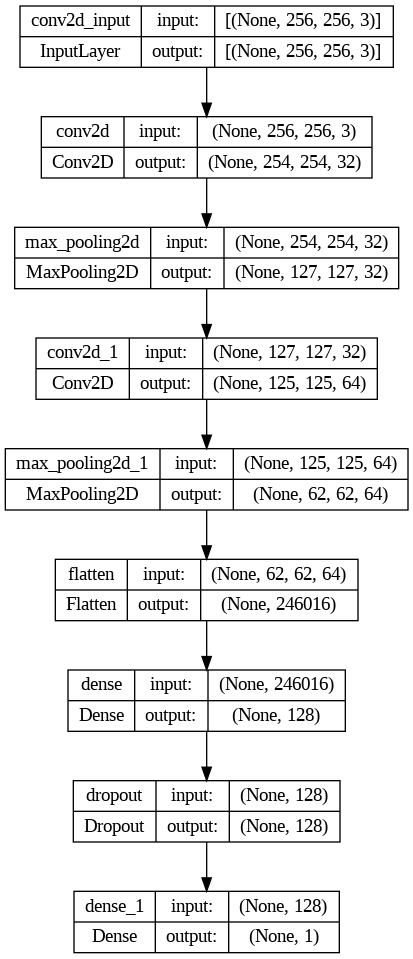

In [ ]:
# Plot layers

tf.keras.utils.plot_model(model_improved, show_shapes=True)

**Architecture Model Improvement diatas sebagai berikut =**
1. Masih sama seperti sebelumnya, menggunakan Sequential API karena :      
  a.  model yang dibuat tidak terlalu kompleks. Hanya satu input dan output layer dengan gambar mempunyai 3 channel warna RGB

2. Untuk Input layer menggunakan convulusion Conv2D dengan 32 filter yang akan memproses 3 channel warna RGB.  

3. Untuk Hidden Layer menggunakan Maxpooling2D seabgai pooling pertama dan Convulusional layer kedua untuk pemrosesan pada gambar.  

4. Untuk layer concat (connect layer) menggunakan :     
  4a. Dense dengan 128 neuron.     
  4b. **Tambahan :** layer dropout 0.5 artinya 50% neuron akan di drop untuk mengurangi overfiting. Karena hasil sebelumnya overfit.      
  4c. flatten sebagai layer convert mengubah 2d menjadi 1D untuk pemrosesan computer vision image.

5. Output Layer dengan activasi sigmoid dikarenakan outpu yang dihasilkan adalah binary classification      

### **Model Training**

In [ ]:
# Train the model
%%time
train_improved = model_improved.fit(train_set_aug, epochs=25, validation_data=val_set_aug, batch_size=batch_size)
# epoch = semakin banyak nilai epoch semakin lama waktu training tetapi hasilnya akan terlihat lebih jelas

Epoch 1/25
29/29 [==============================] - 21s 641ms/step - loss: 1.5361 - accuracy: 0.6605 - val_loss: 0.4360 - val_accuracy: 0.8051
Epoch 2/25
29/29 [==============================] - 21s 709ms/step - loss: 0.4541 - accuracy: 0.7798 - val_loss: 0.4358 - val_accuracy: 0.8205
Epoch 3/25
29/29 [==============================] - 20s 703ms/step - loss: 0.4090 - accuracy: 0.8182 - val_loss: 0.3822 - val_accuracy: 0.8385
Epoch 4/25
29/29 [==============================] - 19s 645ms/step - loss: 0.3802 - accuracy: 0.8324 - val_loss: 0.3727 - val_accuracy: 0.8462
Epoch 5/25
29/29 [==============================] - 19s 673ms/step - loss: 0.3453 - accuracy: 0.8456 - val_loss: 0.3706 - val_accuracy: 0.8615
Epoch 6/25
29/29 [==============================] - 18s 641ms/step - loss: 0.3476 - accuracy: 0.8554 - val_loss: 0.3641 - val_accuracy: 0.8590
Epoch 7/25
29/29 [==============================] - 20s 703ms/step - loss: 0.3294 - accuracy: 0.8576 - val_loss: 0.3483 - val_accuracy: 0.8667

Waktu yang dibutuhkan untuk training model 25 epoch (Gpu t4)
CPU times: user 8min 35s,    
sys: 10.7 s,     
total: 8min 46s   
Wall time: 8min 54s   

Waktu yang dibutuhkan untuk training model 25 epoch (tanpa gpu t4) =     
CPU times: user 1h 15min 38s, sys: 14min 40s,    
total: 1h 30min 19s   
Wall time: 56min 56s

Karena ada penambahan layer tambahan dan data augmentation maka waktu yang dibutuhkan untuk pemrosesan setelah model improvement cenderung melambat dari sebelumnya training non improvement

### **Model Evaluation**

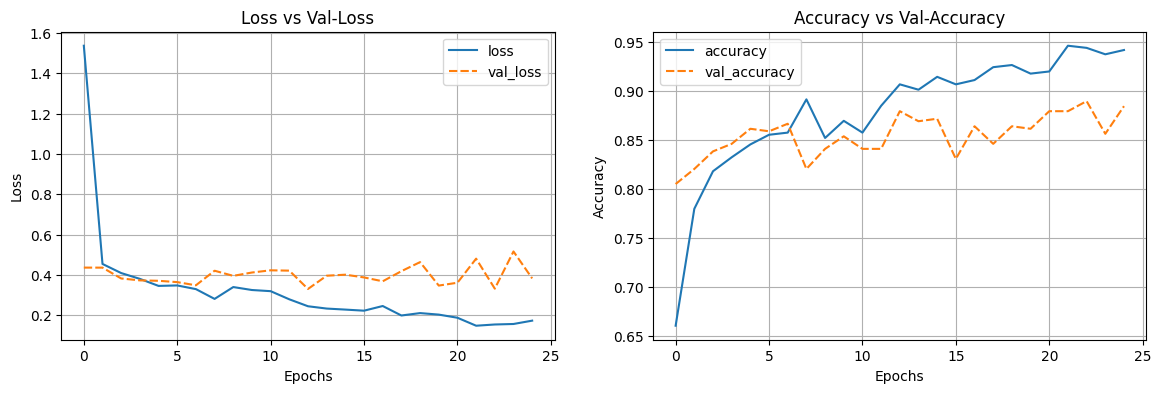

In [ ]:
# Plot training results

train_improved_df = pd.DataFrame(train_improved.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
sns.lineplot(data=train_improved_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=train_improved_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
y_pred_func = model_improved.predict(test_set_aug)
# Convert probabilities to class labels (0 or 1)
y_pred_func = np.where(y_pred_func >= 0.5, 1, 0)

print(classification_report(test_set_aug.classes, y_pred_func, target_names=test_set_aug.class_indices))

7/7 [==============================] - 1s 74ms/step
              precision    recall  f1-score   support

        cars       0.79      0.99      0.88       100
       tanks       0.99      0.73      0.84       100

    accuracy                           0.86       200
   macro avg       0.89      0.86      0.86       200
weighted avg       0.89      0.86      0.86       200



**Berdasarkan model ANN-CNN improvement ada beberapa peningkatan =**       
1. Akurasi Model Non-Improved = 80    
1a. Akurasi Model dengan Improved = 86

2. Rata-rata (f1-score) untuk deteksi cars model Non Improvement = 81     
2a. F1-Score untuk deteksi cars Model Improvement = 88  

3. Rata-rata (f1-score) untuk deteksi Tank model Non Improvement = 79     
2a. F1-Score untuk deteksi Tanks Model Improvement = 86  

4. Dengan menggunakan Dropout layer dan data augmentation model-improvement sudah mendekati **goodfit** untuk loss vs val-loss dan akurasi


## **Model Saving**

In [ ]:
# Freeze model agar tidak 0 di di Non-trainable params
model_improved.trainable = False
model_improved.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 128)               3

In [ ]:
# Save ANN Model in tensorflow h5
model_improved.save('Car-tanks-model.h5')

In [ ]:
# Save ANN Model in Keras
model_improved.save('Car-tanks-model.keras')

## **Model Inference**

In [ ]:
# New notebook

## **Pengambilan Kesimpulan**

**Berdasarkan model Computer Vision ANN-CNN improvement ada beberapa peningkatan =**       
1. Akurasi Model Non-Improved = 80    
1a. Akurasi Model dengan Improved = 86

2. Rata-rata (f1-score) untuk deteksi cars model Non Improvement = 81     
2a. F1-Score untuk deteksi cars Model Improvement = 88  

3. Rata-rata (f1-score) untuk deteksi Tank model Non Improvement = 79     
2a. F1-Score untuk deteksi Tanks Model Improvement = 86  

4. Dengan menggunakan Dropout layer dan data augmentation model sudah mendekati **goodfit** untuk loss vs val-loss dan akurasi

**Kelemahan Model**
1. Waktu training yang dibutuhkan semakin bertambah dikarenakan ada beberapa tambahan layer serta menggunakan preprocessing tamabahan seperti data augmentation.

**Further Improvement**
1. Melakukan setting ulang pada data augmentation sebagai parameter untuk menemukan hasil terbaik.
2. Menambahkan Batch normalisasi dan callback untuk model lebih optimal.